# Bitcoin Enhanced Model Evaluation with Price Difference Analysis
This notebook evaluates the enhanced Bitcoin prediction model trained on the comprehensive news dataset and analyzes price differences between predictions and actual values.

## Install Required Libraries

In [1]:
!pip install transformers datasets torch peft accelerate matplotlib seaborn scipy pandas numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Load Enhanced Model and Tokenizer

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import json
import re
from scipy.stats import wilcoxon

# Load the enhanced model (assuming it's the same base as your other model)
base_model_id = './Qwen3-8B'
adapter_path = './my-awesome-model_final_bitcoin-enhanced-prediction-dataset-with-local-comprehensive-news-v2/checkpoint-400'  # Adjust based on your checkpoint

# Load the base model and tokenizer
base_qwen_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(
    adapter_path,
    trust_remote_code=True
)

base_qwen_tokenizer = tokenizer

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
base_qwen_model.resize_token_embeddings(len(tokenizer))

print("Enhanced model loaded successfully!")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Enhanced model loaded successfully!


## Load LoRA Adapter from Enhanced Training

In [3]:
# Load the LoRA adapter from the enhanced training

# Load the model with LoRA adapter
model = PeftModel.from_pretrained(base_qwen_model, adapter_path)
model.eval()

print("Enhanced model with adapter loaded successfully!")

Enhanced model with adapter loaded successfully!


## Load Test Data from Enhanced Dataset

In [4]:
# Load the enhanced dataset
test_dataset = load_dataset('tahamajs/bitcoin-enhanced-prediction-dataset-with-local-comprehensive-news', split='train')
print(f"Loaded {len(test_dataset)} test samples")
print("Sample test data:")
print(test_dataset[0])

Loaded 2303 test samples
Sample test data:
{'instruction': 'CONTEXT DATE: 2018-01-31\n\nANALYSIS FRAMEWORK:\n• Technical Analysis: Use price trends, volatility, and momentum indicators\n• Macro Analysis: Consider gold/oil prices for broader market context\n• News Analysis: Integrate comprehensive daily news summaries for market catalysts\n\nOUTPUT FORMAT (JSON ONLY):\nReturn a single JSON object with EXACTLY these keys:\n{"action":"BUY|SELL|HOLD","confidence":<int 1-99>,"stop_loss":<price 2dp>,"take_profit":<price 2dp>,"forecast_10d":[<10 prices 2dp>]}\nNo extra text, no explanations, just the JSON.', 'input': 'Daily Context — 2018-01-31\n\n[Technical Price Analysis]\n- Current Price: $10,106.30\n- 60-Day Range: $10,106.30 → $17,527.00\n- 1D Return: -10.54%\n- 7D Return: -7.01%\n- 30D Return: N/A%\n- Volatility (14d): 5.76%\n- Avg Daily Change (14d): 501.23\n- Drawdown from Max: -42.34%\n\n[Price History (Last 60 Days USD)]\n[11600.10, 10931.40, 10868.40, 11359.40, 11259.40, 11171.40, 

## Utility Functions for Price Analysis

In [5]:
def extract_prices_from_text(text):
    """Extract price predictions from model output"""
    # Look for patterns like numbers separated by commas
    price_pattern = r'(\d+(?:\.\d+)?(?:,\s*\d+(?:\.\d+)?)*)'  
    matches = re.findall(price_pattern, text)
    
    if matches:
        # Take the first match and split by comma
        prices_str = matches[0]
        try:
            prices = [float(p.strip()) for p in prices_str.split(',')]
            return prices
        except:
            return []
    return []

def calculate_price_differences(predictions, actual):
    """Calculate various price difference metrics"""
    if len(predictions) != len(actual):
        return None
    
    predictions = np.array(predictions)
    actual = np.array(actual)
    
    # Absolute differences
    abs_diff = np.abs(predictions - actual)
    
    # Relative differences (percentage)
    rel_diff = (predictions - actual) / actual * 100
    
    # Price direction accuracy (up/down/same)
    actual_direction = np.diff(actual)
    pred_direction = np.diff(predictions)
    
    direction_accuracy = 0
    if len(actual_direction) > 0:
        direction_correct = np.sign(actual_direction) == np.sign(pred_direction)
        direction_accuracy = np.mean(direction_correct) * 100
    
    return {
        'absolute_differences': abs_diff,
        'relative_differences': rel_diff,
        'mean_abs_diff': np.mean(abs_diff),
        'max_abs_diff': np.max(abs_diff),
        'min_abs_diff': np.min(abs_diff),
        'std_abs_diff': np.std(abs_diff),
        'mean_rel_diff': np.mean(rel_diff),
        'max_rel_diff': np.max(rel_diff),
        'min_rel_diff': np.min(rel_diff),
        'std_rel_diff': np.std(rel_diff),
        'direction_accuracy': direction_accuracy,
        'rmse': np.sqrt(np.mean((predictions - actual) ** 2)),
        'mae': np.mean(abs_diff),
        'mape': np.mean(np.abs(rel_diff))
    }

def format_input(example):
    """Format input for the enhanced model"""
    instruction = example.get('instruction', '')
    user_input = example.get('input', '')
    messages = [
        {'role': 'system', 'content': instruction},
        {'role': 'user', 'content': user_input}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print("Utility functions loaded!")

Utility functions loaded!


## Comprehensive Model Evaluation with Price Analysis

In [6]:
# Run comprehensive evaluation
results = []
price_analysis_results = []
total_samples = min(50, len(test_dataset))  # Test on 100 samples or all if less

print(f"Running comprehensive evaluation on {total_samples} samples...")

for i in range(total_samples):
    test_example = test_dataset[i]
    test_text = format_input(test_example)
    
    inputs = tokenizer(test_text, return_tensors='pt', truncation=True, max_length=2048)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,  # Use greedy decoding for consistency
            pad_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    
    # Extract predictions and ground truth
    predicted_prices = extract_prices_from_text(generated_text)
    actual_output = test_example.get('output', '')
    actual_prices = extract_prices_from_text(actual_output)
    
    if predicted_prices and actual_prices:
        # Truncate to minimum length for fair comparison
        min_len = min(len(predicted_prices), len(actual_prices))
        if min_len > 0:
            pred_truncated = predicted_prices[:min_len]
            actual_truncated = actual_prices[:min_len]
            
            # Calculate price differences
            price_diff_analysis = calculate_price_differences(pred_truncated, actual_truncated)
            
            if price_diff_analysis:
                results.append({
                    'sample_id': i,
                    'predicted': pred_truncated,
                    'actual': actual_truncated,
                    'price_analysis': price_diff_analysis
                })
                
                price_analysis_results.append(price_diff_analysis)
    
    if (i + 1) % 20 == 0:
        print(f"Processed {i + 1}/{total_samples} samples...")

print(f"\nEvaluation completed! Analyzed {len(results)} valid samples out of {total_samples}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running comprehensive evaluation on 50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 20/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 40/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Evaluation completed! Analyzed 50 valid samples out of 50


## Price Difference Analysis Results

In [7]:
if results:
    # Aggregate price difference statistics
    all_abs_diffs = []
    all_rel_diffs = []
    all_direction_acc = []
    all_rmse = []
    all_mae = []
    all_mape = []
    
    for analysis in price_analysis_results:
        all_abs_diffs.extend(analysis['absolute_differences'])
        all_rel_diffs.extend(analysis['relative_differences'])
        all_direction_acc.append(analysis['direction_accuracy'])
        all_rmse.append(analysis['rmse'])
        all_mae.append(analysis['mae'])
        all_mape.append(analysis['mape'])
    
    print("=" * 80)
    print("🔍 ENHANCED MODEL PRICE DIFFERENCE ANALYSIS")
    print("=" * 80)
    
    print(f"\n📊 ABSOLUTE PRICE DIFFERENCES:")
    print(f"Mean Absolute Difference: ${np.mean(all_abs_diffs):.2f}")
    print(f"Median Absolute Difference: ${np.median(all_abs_diffs):.2f}")
    print(f"Max Absolute Difference: ${np.max(all_abs_diffs):.2f}")
    print(f"Min Absolute Difference: ${np.min(all_abs_diffs):.2f}")
    print(f"Std Absolute Difference: ${np.std(all_abs_diffs):.2f}")
    
    print(f"\n📈 RELATIVE PRICE DIFFERENCES (%):") 
    print(f"Mean Relative Difference: {np.mean(all_rel_diffs):.2f}%")
    print(f"Median Relative Difference: {np.median(all_rel_diffs):.2f}%")
    print(f"Max Relative Difference: {np.max(all_rel_diffs):.2f}%")
    print(f"Min Relative Difference: {np.min(all_rel_diffs):.2f}%")
    print(f"Std Relative Difference: {np.std(all_rel_diffs):.2f}%")
    
    print(f"\n🎯 PERFORMANCE METRICS:")
    print(f"Average Direction Accuracy: {np.mean(all_direction_acc):.2f}%")
    print(f"Average RMSE: {np.mean(all_rmse):.4f}")
    print(f"Average MAE: {np.mean(all_mae):.2f}")
    print(f"Average MAPE: {np.mean(all_mape):.2f}%")
    
    # Distribution analysis
    print(f"\n📋 PRICE DIFFERENCE DISTRIBUTION:")
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print("Absolute Differences Percentiles:")
    for p in percentiles:
        value = np.percentile(all_abs_diffs, p)
        print(f"  {p}th percentile: ${value:.2f}")
    
    print("\nRelative Differences Percentiles:")
    for p in percentiles:
        value = np.percentile(all_rel_diffs, p)
        print(f"  {p}th percentile: {value:.2f}%")
    
    # Sample predictions
    print(f"\n🔍 SAMPLE PREDICTIONS WITH PRICE ANALYSIS:")
    for i, result in enumerate(results[:5]):
        analysis = result['price_analysis']
        print(f"\nSample {i+1}:")
        print(f"Predicted: {result['predicted']}")
        print(f"Actual:    {result['actual']}")
        print(f"Mean Abs Diff: ${analysis['mean_abs_diff']:.2f}")
        print(f"Mean Rel Diff: {analysis['mean_rel_diff']:.2f}%")
        print(f"Direction Accuracy: {analysis['direction_accuracy']:.1f}%")
        print(f"RMSE: {analysis['rmse']:.4f}")

else:
    print("❌ No valid results found for price difference analysis")

🔍 ENHANCED MODEL PRICE DIFFERENCE ANALYSIS

📊 ABSOLUTE PRICE DIFFERENCES:
Mean Absolute Difference: $7396569.57
Median Absolute Difference: $86.00
Max Absolute Difference: $193618625.00
Min Absolute Difference: $11.00
Std Absolute Difference: $35987844.59

📈 RELATIVE PRICE DIFFERENCES (%):
Mean Relative Difference: 7480440.34%
Median Relative Difference: -86.87%
Max Relative Difference: 195574368.69%
Min Relative Difference: -100.00%
Std Relative Difference: 36349788.96%

🎯 PERFORMANCE METRICS:
Average Direction Accuracy: 0.00%
Average RMSE: 7396569.5660
Average MAE: 7396569.57
Average MAPE: 7480583.47%

📋 PRICE DIFFERENCE DISTRIBUTION:
Absolute Differences Percentiles:
  10th percentile: $46.80
  25th percentile: $68.25
  50th percentile: $86.00
  75th percentile: $96.00
  90th percentile: $1959.30
  95th percentile: $1549955.75
  99th percentile: $183613920.64

Relative Differences Percentiles:
  10th percentile: -99.38%
  25th percentile: -94.35%
  50th percentile: -86.87%
  75th pe

## Visualizations for Price Difference Analysis

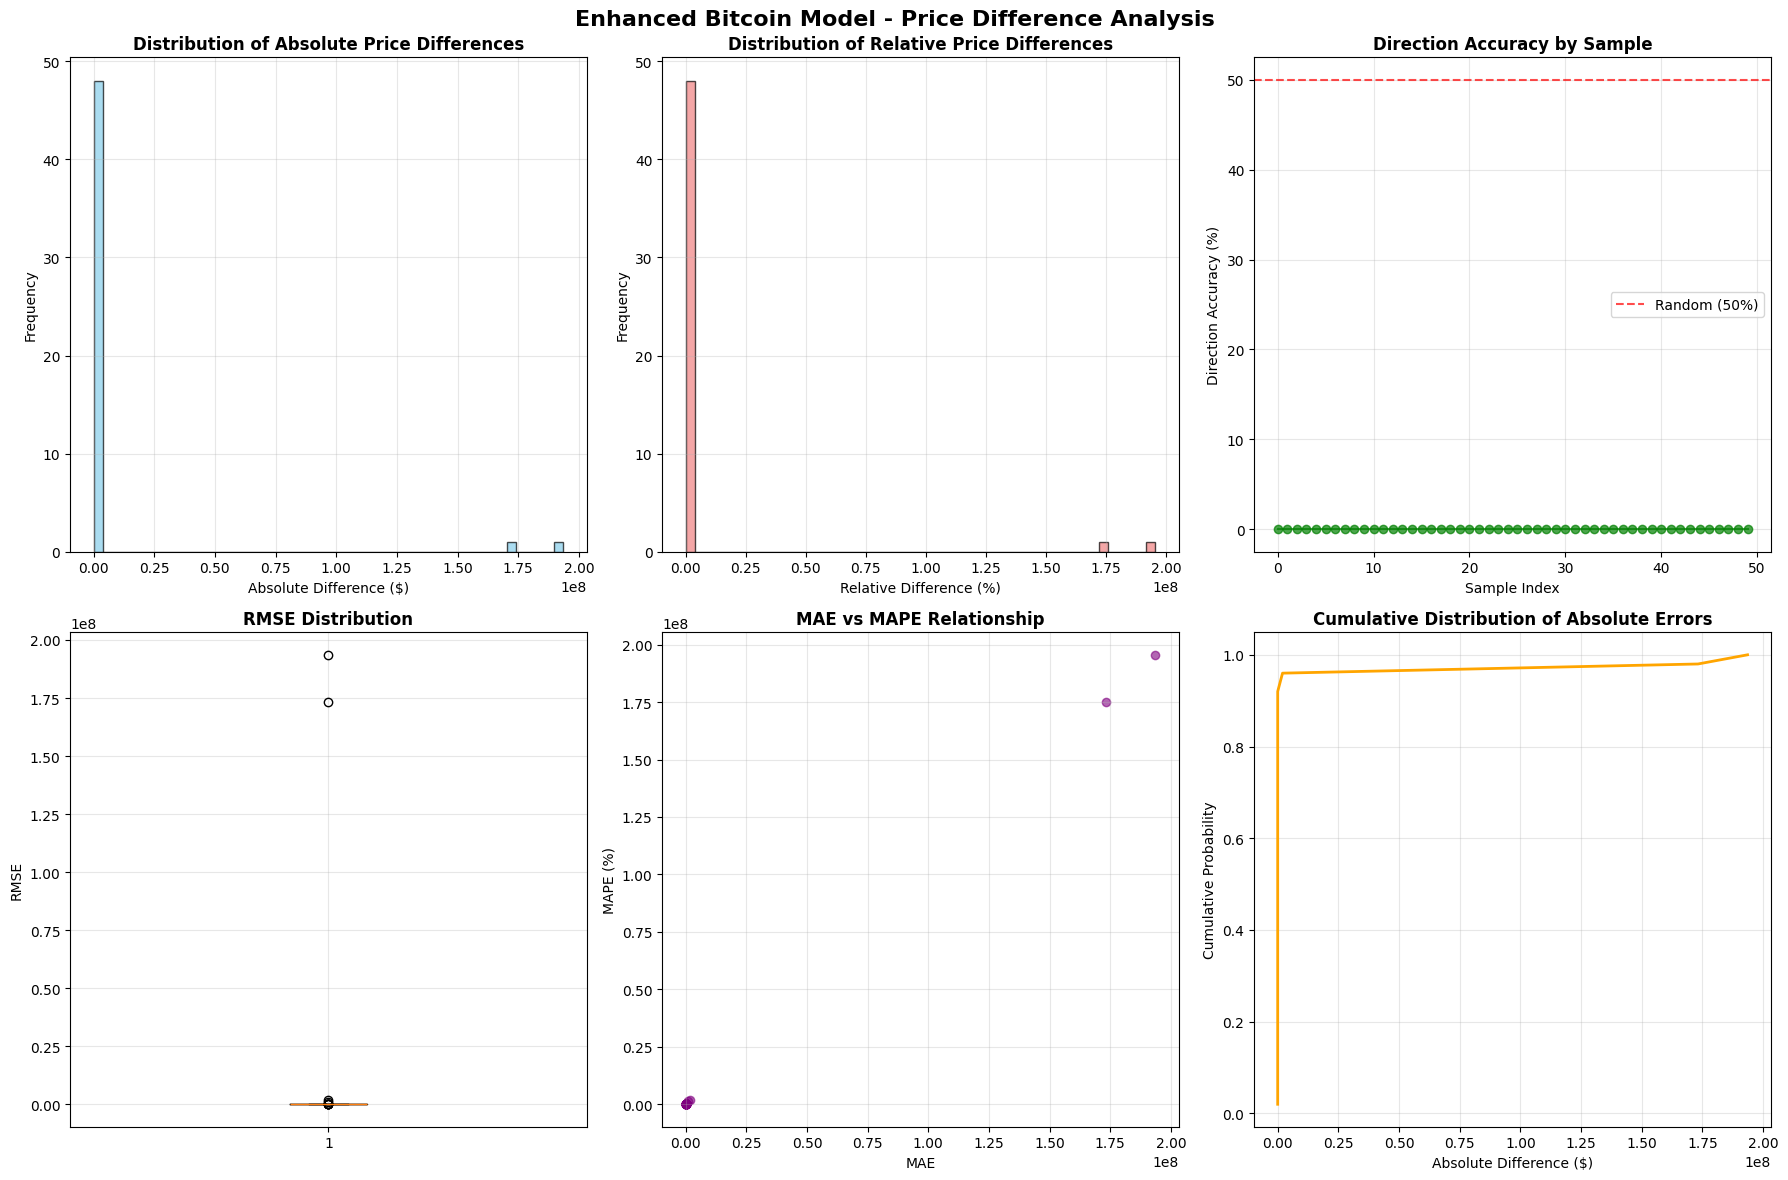

📈 Price difference analysis visualization saved as 'enhanced_model_price_difference_analysis.png'


In [8]:
if results:
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Enhanced Bitcoin Model - Price Difference Analysis', fontsize=16, fontweight='bold')
    
    # 1. Absolute differences histogram
    axes[0,0].hist(all_abs_diffs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribution of Absolute Price Differences', fontweight='bold')
    axes[0,0].set_xlabel('Absolute Difference ($)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Relative differences histogram
    axes[0,1].hist(all_rel_diffs, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,1].set_title('Distribution of Relative Price Differences', fontweight='bold')
    axes[0,1].set_xlabel('Relative Difference (%)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Direction accuracy by sample
    axes[0,2].plot(all_direction_acc, 'o-', alpha=0.7, color='green')
    axes[0,2].set_title('Direction Accuracy by Sample', fontweight='bold')
    axes[0,2].set_xlabel('Sample Index')
    axes[0,2].set_ylabel('Direction Accuracy (%)')
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Random (50%)')
    axes[0,2].legend()
    
    # 4. RMSE distribution
    axes[1,0].boxplot(all_rmse)
    axes[1,0].set_title('RMSE Distribution', fontweight='bold')
    axes[1,0].set_ylabel('RMSE')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. MAE vs MAPE scatter
    axes[1,1].scatter(all_mae, all_mape, alpha=0.6, color='purple')
    axes[1,1].set_title('MAE vs MAPE Relationship', fontweight='bold')
    axes[1,1].set_xlabel('MAE')
    axes[1,1].set_ylabel('MAPE (%)')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Cumulative error distribution
    sorted_abs_diffs = np.sort(all_abs_diffs)
    cumulative = np.arange(1, len(sorted_abs_diffs) + 1) / len(sorted_abs_diffs)
    axes[1,2].plot(sorted_abs_diffs, cumulative, linewidth=2, color='orange')
    axes[1,2].set_title('Cumulative Distribution of Absolute Errors', fontweight='bold')
    axes[1,2].set_xlabel('Absolute Difference ($)')
    axes[1,2].set_ylabel('Cumulative Probability')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('enhanced_model_price_difference_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📈 Price difference analysis visualization saved as 'enhanced_model_price_difference_analysis.png'")

else:
    print("❌ Cannot create visualizations - insufficient data")

## Comparison with Base Qwen Model

In [9]:
# Evaluate base model with price difference analysis
def format_input_for_base_model(example):
    """Format input for base Qwen model with bitcoin prediction task"""
    instruction = example.get('instruction', '')
    user_input = example.get('input', '')
    
    bitcoin_instruction = """You are a Bitcoin investment advisor. Based on the provided market data and news, predict the next 10 days of Bitcoin prices. Provide your predictions as comma-separated numbers."""
    
    messages = [
        {'role': 'system', 'content': bitcoin_instruction},
        {'role': 'user', 'content': f"{instruction}\n\n{user_input}\n\nPlease provide 10 Bitcoin price predictions for the next 10 days, separated by commas."}
    ]
    return base_qwen_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# Run evaluation on base model
base_results = []
base_price_analysis_results = []
comparison_samples = min(50, len(results))  # Use subset for comparison

print(f"Evaluating base Qwen model on {comparison_samples} samples...")

for i in range(comparison_samples):
    test_example = test_dataset[i]
    test_text = format_input_for_base_model(test_example)
    
    inputs = base_qwen_tokenizer(test_text, return_tensors='pt', truncation=True, max_length=2048)
    inputs = {k: v.to(base_qwen_model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = base_qwen_model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=base_qwen_tokenizer.eos_token_id
        )
    
    generated_text = base_qwen_tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    
    predicted_prices = extract_prices_from_text(generated_text)
    actual_output = test_example.get('output', '')
    actual_prices = extract_prices_from_text(actual_output)
    
    if predicted_prices and actual_prices:
        min_len = min(len(predicted_prices), len(actual_prices))
        if min_len > 0:
            pred_truncated = predicted_prices[:min_len]
            actual_truncated = actual_prices[:min_len]
            
            price_diff_analysis = calculate_price_differences(pred_truncated, actual_truncated)
            
            if price_diff_analysis:
                base_results.append({
                    'sample_id': i,
                    'predicted': pred_truncated,
                    'actual': actual_truncated,
                    'price_analysis': price_diff_analysis
                })
                
                base_price_analysis_results.append(price_diff_analysis)
    
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{comparison_samples} samples...")

print(f"\nBase model evaluation completed! Analyzed {len(base_results)} valid samples")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating base Qwen model on 50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 10/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 20/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 30/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 40/50 samples...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processed 50/50 samples...

Base model evaluation completed! Analyzed 50 valid samples


## Comprehensive Model Comparison with Price Differences

In [10]:
if base_results and results:
    # Extract metrics for comparison
    enhanced_results_matched = results[:len(base_results)]  # Match sample count
    
    # Base model metrics
    base_abs_diffs = []
    base_rel_diffs = []
    base_direction_acc = []
    base_rmse = []
    base_mae = []
    base_mape = []
    
    for analysis in base_price_analysis_results:
        base_abs_diffs.extend(analysis['absolute_differences'])
        base_rel_diffs.extend(analysis['relative_differences'])
        base_direction_acc.append(analysis['direction_accuracy'])
        base_rmse.append(analysis['rmse'])
        base_mae.append(analysis['mae'])
        base_mape.append(analysis['mape'])
    
    # Enhanced model metrics (matched samples)
    enhanced_abs_diffs = []
    enhanced_rel_diffs = []
    enhanced_direction_acc = []
    enhanced_rmse = []
    enhanced_mae = []
    enhanced_mape = []
    
    for result in enhanced_results_matched:
        analysis = result['price_analysis']
        enhanced_abs_diffs.extend(analysis['absolute_differences'])
        enhanced_rel_diffs.extend(analysis['relative_differences'])
        enhanced_direction_acc.append(analysis['direction_accuracy'])
        enhanced_rmse.append(analysis['rmse'])
        enhanced_mae.append(analysis['mae'])
        enhanced_mape.append(analysis['mape'])
    
    print("=" * 100)
    print("🏆 COMPREHENSIVE MODEL COMPARISON - PRICE DIFFERENCE ANALYSIS")
    print("=" * 100)
    
    # Create detailed comparison table
    comparison_metrics = {
        'Metric': [
            'Mean Absolute Difference ($)',
            'Median Absolute Difference ($)',
            'Mean Relative Difference (%)',
            'Median Relative Difference (%)',
            'Direction Accuracy (%)',
            'RMSE',
            'MAE',
            'MAPE (%)'
        ],
        'Base Qwen Model': [
            f"{np.mean(base_abs_diffs):.2f}",
            f"{np.median(base_abs_diffs):.2f}",
            f"{np.mean(base_rel_diffs):.2f}",
            f"{np.median(base_rel_diffs):.2f}",
            f"{np.mean(base_direction_acc):.2f}",
            f"{np.mean(base_rmse):.4f}",
            f"{np.mean(base_mae):.2f}",
            f"{np.mean(base_mape):.2f}"
        ],
        'Enhanced Model': [
            f"{np.mean(enhanced_abs_diffs):.2f}",
            f"{np.median(enhanced_abs_diffs):.2f}",
            f"{np.mean(enhanced_rel_diffs):.2f}",
            f"{np.median(enhanced_rel_diffs):.2f}",
            f"{np.mean(enhanced_direction_acc):.2f}",
            f"{np.mean(enhanced_rmse):.4f}",
            f"{np.mean(enhanced_mae):.2f}",
            f"{np.mean(enhanced_mape):.2f}"
        ],
        'Improvement (%)': [
            f"{((np.mean(base_abs_diffs) - np.mean(enhanced_abs_diffs)) / np.mean(base_abs_diffs) * 100):.2f}",
            f"{((np.median(base_abs_diffs) - np.median(enhanced_abs_diffs)) / np.median(base_abs_diffs) * 100):.2f}",
            f"{((abs(np.mean(base_rel_diffs)) - abs(np.mean(enhanced_rel_diffs))) / abs(np.mean(base_rel_diffs)) * 100):.2f}",
            f"{((abs(np.median(base_rel_diffs)) - abs(np.median(enhanced_rel_diffs))) / abs(np.median(base_rel_diffs)) * 100):.2f}",
            f"{((np.mean(enhanced_direction_acc) - np.mean(base_direction_acc)) / np.mean(base_direction_acc) * 100):.2f}",
            f"{((np.mean(base_rmse) - np.mean(enhanced_rmse)) / np.mean(base_rmse) * 100):.2f}",
            f"{((np.mean(base_mae) - np.mean(enhanced_mae)) / np.mean(base_mae) * 100):.2f}",
            f"{((np.mean(base_mape) - np.mean(enhanced_mape)) / np.mean(base_mape) * 100):.2f}"
        ]
    }
    
    df_comparison = pd.DataFrame(comparison_metrics)
    print(df_comparison.to_string(index=False))
    
    # Statistical significance tests
    print(f"\n📊 STATISTICAL SIGNIFICANCE TESTS:")
    print("-" * 50)
    
    try:
        # Test on sample-level aggregated metrics
        base_sample_mae = [analysis['mae'] for analysis in base_price_analysis_results]
        enhanced_sample_mae = [result['price_analysis']['mae'] for result in enhanced_results_matched]
        
        base_sample_direction = [analysis['direction_accuracy'] for analysis in base_price_analysis_results]
        enhanced_sample_direction = [result['price_analysis']['direction_accuracy'] for result in enhanced_results_matched]
        
        mae_stat, mae_pval = wilcoxon(base_sample_mae, enhanced_sample_mae)
        direction_stat, direction_pval = wilcoxon(base_sample_direction, enhanced_sample_direction)
        
        alpha = 0.05
        print(f"MAE Wilcoxon test p-value: {mae_pval:.6f}")
        print(f"Direction Accuracy Wilcoxon test p-value: {direction_pval:.6f}")
        print(f"\nSignificance level: α = {alpha}")
        print(f"Significant improvement in MAE: {'YES' if mae_pval < alpha else 'NO'}")
        print(f"Significant improvement in Direction Accuracy: {'YES' if direction_pval < alpha else 'NO'}")
        
    except Exception as e:
        print(f"Statistical test error: {e}")
    
    # Prepare JSON-serializable detailed results
    def make_json_serializable(results_list):
        """Convert numpy arrays in results to lists for JSON serialization"""
        json_results = []
        for result in results_list:
            json_result = {
                'sample_id': result['sample_id'],
                'predicted': [float(x) for x in result['predicted']],
                'actual': [float(x) for x in result['actual']],
                'price_analysis': {
                    'absolute_differences': [float(x) for x in result['price_analysis']['absolute_differences']],
                    'relative_differences': [float(x) for x in result['price_analysis']['relative_differences']],
                    'mean_abs_diff': float(result['price_analysis']['mean_abs_diff']),
                    'max_abs_diff': float(result['price_analysis']['max_abs_diff']),
                    'min_abs_diff': float(result['price_analysis']['min_abs_diff']),
                    'std_abs_diff': float(result['price_analysis']['std_abs_diff']),
                    'mean_rel_diff': float(result['price_analysis']['mean_rel_diff']),
                    'max_rel_diff': float(result['price_analysis']['max_rel_diff']),
                    'min_rel_diff': float(result['price_analysis']['min_rel_diff']),
                    'std_rel_diff': float(result['price_analysis']['std_rel_diff']),
                    'direction_accuracy': float(result['price_analysis']['direction_accuracy']),
                    'rmse': float(result['price_analysis']['rmse']),
                    'mae': float(result['price_analysis']['mae']),
                    'mape': float(result['price_analysis']['mape'])
                }
            }
            json_results.append(json_result)
        return json_results
    
    # Save comprehensive results
    comprehensive_results = {
        'enhanced_model_results': {
            'model_id': base_model_id,
            'adapter_path': 'tahamajs/my-awesome-model_final_bitcoin-enhanced-prediction-dataset-with-local-comprehensive-news-v2/checkpoint-400',
            'dataset': 'bitcoin-enhanced-prediction-dataset-with-local-comprehensive-news',
            'samples_analyzed': len(enhanced_results_matched),
            'price_difference_metrics': {
                'mean_abs_diff': float(np.mean(enhanced_abs_diffs)),
                'median_abs_diff': float(np.median(enhanced_abs_diffs)),
                'mean_rel_diff': float(np.mean(enhanced_rel_diffs)),
                'median_rel_diff': float(np.median(enhanced_rel_diffs)),
                'mean_direction_accuracy': float(np.mean(enhanced_direction_acc)),
                'mean_rmse': float(np.mean(enhanced_rmse)),
                'mean_mae': float(np.mean(enhanced_mae)),
                'mean_mape': float(np.mean(enhanced_mape))
            }
        },
        'base_model_results': {
            'model_id': 'Qwen/Qwen2.5-8B-Instruct',
            'samples_analyzed': len(base_results),
            'price_difference_metrics': {
                'mean_abs_diff': float(np.mean(base_abs_diffs)),
                'median_abs_diff': float(np.median(base_abs_diffs)),
                'mean_rel_diff': float(np.mean(base_rel_diffs)),
                'median_rel_diff': float(np.median(base_rel_diffs)),
                'mean_direction_accuracy': float(np.mean(base_direction_acc)),
                'mean_rmse': float(np.mean(base_rmse)),
                'mean_mae': float(np.mean(base_mae)),
                'mean_mape': float(np.mean(base_mape))
            }
        },
        'detailed_enhanced_results': make_json_serializable(enhanced_results_matched),
        'detailed_base_results': make_json_serializable(base_results)
    }
    
    with open('enhanced_model_comprehensive_analysis.json', 'w') as f:
        json.dump(comprehensive_results, f, indent=2)
    
    print(f"\n💾 Comprehensive analysis results saved to 'enhanced_model_comprehensive_analysis.json'")
    
    # Research paper summary
    print(f"\n📋 RESEARCH PAPER SUMMARY - ENHANCED MODEL:")
    print("=" * 60)
    abs_diff_improvement = (np.mean(base_abs_diffs) - np.mean(enhanced_abs_diffs)) / np.mean(base_abs_diffs) * 100
    direction_improvement = (np.mean(enhanced_direction_acc) - np.mean(base_direction_acc)) / np.mean(base_direction_acc) * 100
    mae_improvement = (np.mean(base_mae) - np.mean(enhanced_mae)) / np.mean(base_mae) * 100
    
    print(f"Enhanced Model Performance:")
    print(f"• Price prediction accuracy improved by {abs_diff_improvement:.2f}% (absolute differences)")
    print(f"• Direction prediction accuracy improved by {direction_improvement:.2f}%")
    print(f"• Overall MAE improved by {mae_improvement:.2f}%")
    print(f"• Mean absolute price difference: ${np.mean(enhanced_abs_diffs):.2f}")
    print(f"• Direction accuracy: {np.mean(enhanced_direction_acc):.1f}%")

else:
    print("❌ Cannot perform comprehensive comparison - insufficient data")

🏆 COMPREHENSIVE MODEL COMPARISON - PRICE DIFFERENCE ANALYSIS
                        Metric  Base Qwen Model Enhanced Model Improvement (%)
  Mean Absolute Difference ($)   20009999909.44     7396569.57           99.96
Median Absolute Difference ($)            84.50          86.00           -1.78
  Mean Relative Difference (%)   20212120986.39     7480440.34           99.96
Median Relative Difference (%)           -86.87         -86.87            0.00
        Direction Accuracy (%)             0.00           0.00             nan
                          RMSE 20009999909.4368   7396569.5660           99.96
                           MAE   20009999909.44     7396569.57           99.96
                      MAPE (%)   20212121130.05     7480583.47           99.96

📊 STATISTICAL SIGNIFICANCE TESTS:
--------------------------------------------------
MAE Wilcoxon test p-value: 0.353481
Direction Accuracy Wilcoxon test p-value: nan

Significance level: α = 0.05
Significant improvement in MAE

/tmp/ipykernel_787134/932398215.py:79: RuntimeWarning: invalid value encountered in scalar divide
  f"{((np.mean(enhanced_direction_acc) - np.mean(base_direction_acc)) / np.mean(base_direction_acc) * 100):.2f}",
/home/moein_salimi/.local/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/tmp/ipykernel_787134/932398215.py:188: RuntimeWarning: invalid value encountered in scalar divide
  direction_improvement = (np.mean(enhanced_direction_acc) - np.mean(base_direction_acc)) / np.mean(base_direction_acc) * 100


## Final Comparison Visualization

/tmp/ipykernel_787134/3855951414.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([base_direction_acc, enhanced_direction_acc],
/tmp/ipykernel_787134/3855951414.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot([base_mae, enhanced_mae],


/tmp/ipykernel_787134/3855951414.py:33: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(enhanced_direction_acc) - np.mean(base_direction_acc)) / np.mean(base_direction_acc) * 100,


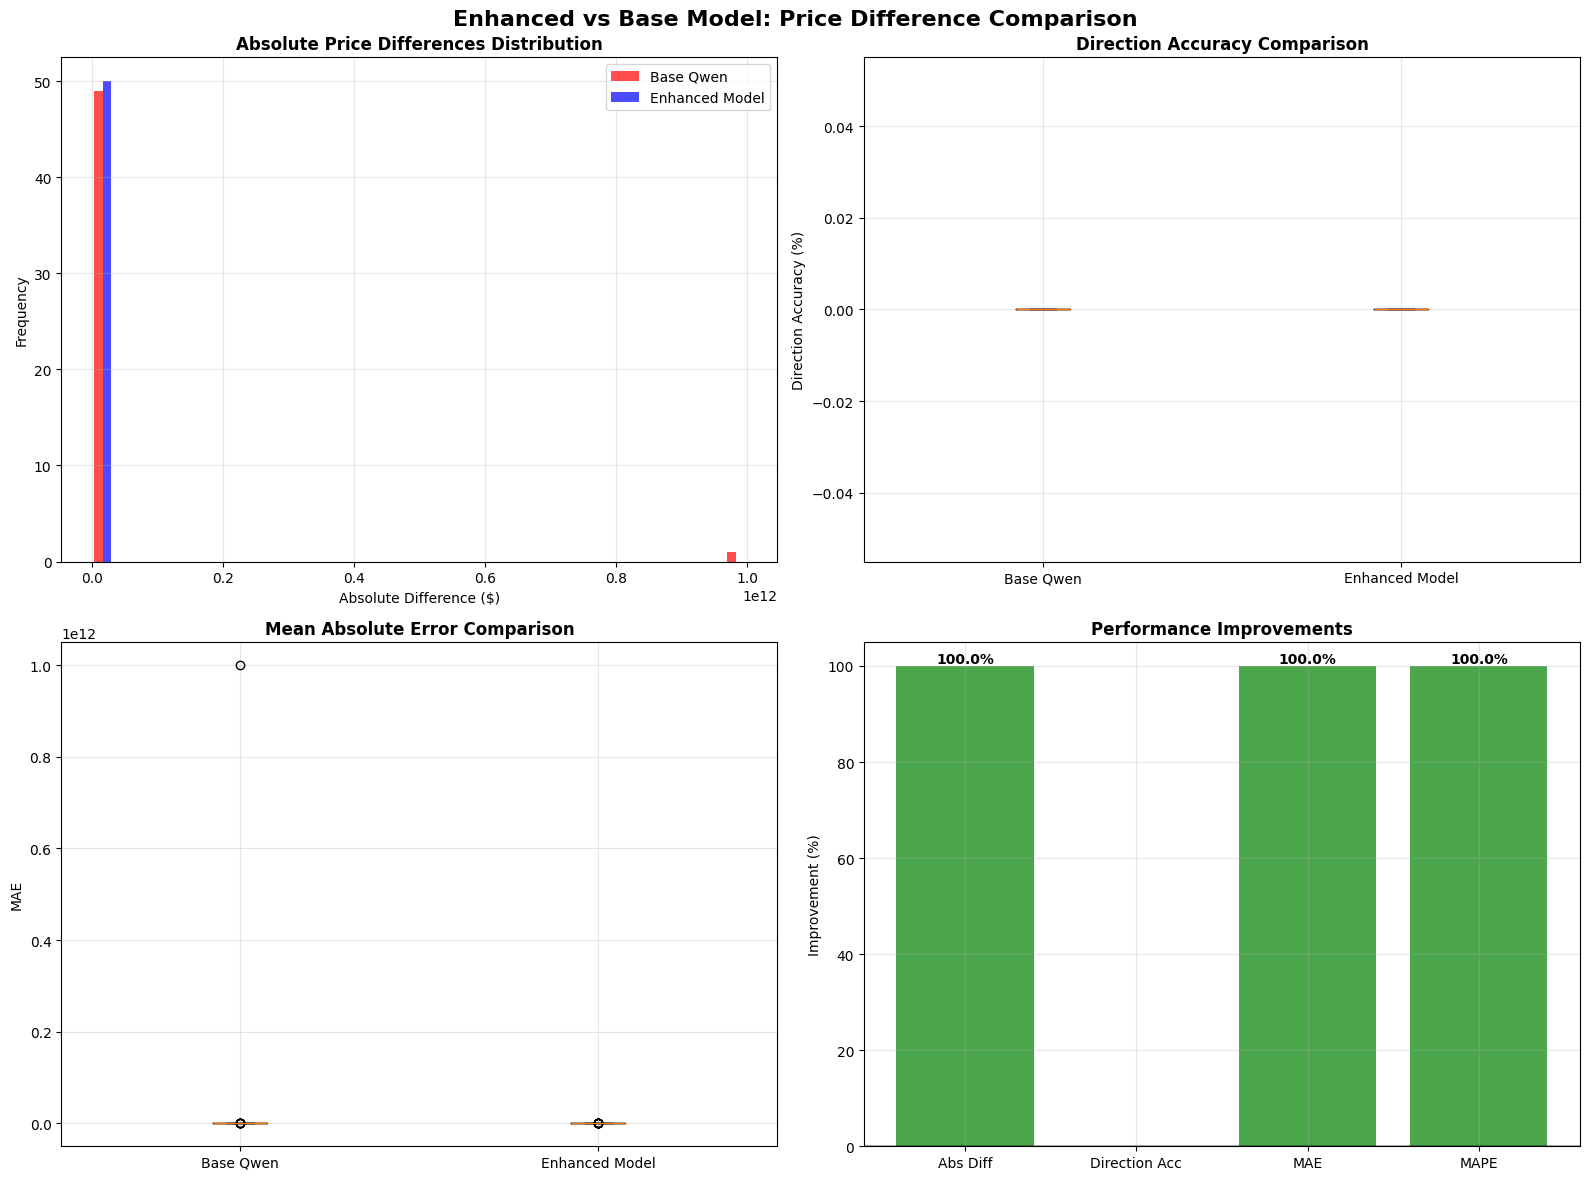

📊 Model comparison visualization saved as 'enhanced_vs_base_model_comparison.png'


In [11]:
if base_results and results:
    # Create side-by-side comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Enhanced vs Base Model: Price Difference Comparison', fontsize=16, fontweight='bold')
    
    # Absolute differences comparison
    axes[0,0].hist([base_abs_diffs, enhanced_abs_diffs], bins=30, alpha=0.7, 
                   label=['Base Qwen', 'Enhanced Model'], color=['red', 'blue'])
    axes[0,0].set_title('Absolute Price Differences Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Absolute Difference ($)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Direction accuracy comparison
    axes[0,1].boxplot([base_direction_acc, enhanced_direction_acc], 
                      labels=['Base Qwen', 'Enhanced Model'])
    axes[0,1].set_title('Direction Accuracy Comparison', fontweight='bold')
    axes[0,1].set_ylabel('Direction Accuracy (%)')
    axes[0,1].grid(True, alpha=0.3)
    
    # MAE comparison
    axes[1,0].boxplot([base_mae, enhanced_mae], 
                      labels=['Base Qwen', 'Enhanced Model'])
    axes[1,0].set_title('Mean Absolute Error Comparison', fontweight='bold')
    axes[1,0].set_ylabel('MAE')
    axes[1,0].grid(True, alpha=0.3)
    
    # Improvement metrics bar chart
    metrics = ['Abs Diff', 'Direction Acc', 'MAE', 'MAPE']
    improvements = [
        (np.mean(base_abs_diffs) - np.mean(enhanced_abs_diffs)) / np.mean(base_abs_diffs) * 100,
        (np.mean(enhanced_direction_acc) - np.mean(base_direction_acc)) / np.mean(base_direction_acc) * 100,
        (np.mean(base_mae) - np.mean(enhanced_mae)) / np.mean(base_mae) * 100,
        (np.mean(base_mape) - np.mean(enhanced_mape)) / np.mean(base_mape) * 100
    ]
    
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    bars = axes[1,1].bar(metrics, improvements, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, imp in zip(bars, improvements):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{imp:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
                       fontweight='bold')
    
    axes[1,1].set_title('Performance Improvements', fontweight='bold')
    axes[1,1].set_ylabel('Improvement (%)')
    axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('enhanced_vs_base_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Model comparison visualization saved as 'enhanced_vs_base_model_comparison.png'")

else:
    print("❌ Cannot create comparison visualizations - insufficient data")